In [2]:
import numpy as np
import pandas as pd
import gc
import time
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
warnings.simplefilter(action='ignore', category=FutureWarning)

import re
import pickle

In [3]:
data = pd.read_csv('processed_data_naninf_filled.csv', index_col='SK_ID_CURR', encoding ='utf-8')

In [32]:
TARGET = pd.DataFrame(data.TARGET)
data = data.drop('TARGET', 1)

In [33]:
data = data.drop('Unnamed: 0', 1)
data = data.drop('index', 1)

In [34]:
TARGET

,TARGET
SK_ID_CURR,
100002,1.0
100003,0.0
100004,0.0
100006,0.0
100007,0.0
...,...
456221,0.0
456222,0.0
456223,0.0


In [6]:
#data = data.head(5000)
#TARGET = TARGET.head(5000)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.values, TARGET.values, test_size=0.3, random_state=42)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((249375, 795), (106876, 795), (249375, 1), (106876, 1))

In [9]:
# Fonction de représentation des résultats

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(30):
            features.append(data.columns[indices[i]])

        sns.barplot(x=features, y=model.feature_importances_[indices[range(30)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

        plt.show()

In [10]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 


models = [
          LGBMClassifier(),#device='gpu'),
          XGBClassifier()]#tree_method='gpu_hist', predictor='gpu_predictor')]

In [11]:
# Fonction de calcul des métriques

def train_models(model, X_train, X_test, y_train, y_test):
    
    parameters = {'nthread':[4],
              'learning_rate': [0.05], #eta, testé entre 0,001 0,05
              'max_depth': [6], # testé entre 3 et 8
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7], # testé entre 0.5 et 1
              'n_estimators': [300], # testé entre 100 et 700
              'missing':[-999],
              'seed': [1337]}
    
    clf = GridSearchCV(model, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(10), 
                   scoring='roc_auc',
                   verbose=2)    
    
    model.fit(X_train, y_train)
    
    # Best Model
    #best_model = clf.best_estimator_

    # Model Parameters
    #print("Best Model's Params: ", clf.best_params_)

    # Log Likelihood Score
    #print("Mean AUC Score: ", clf.best_score_)
    
    #grille_resultats = pd.DataFrame(clf.cv_results_)
    
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test)),
      'modele': model
      }
    
    return output #, grille_resultats

In [99]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []
grilles =[]
modele_trained= []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)#, grille
    name.append(type(model).__name__)
    auc.append(round(results['AUC'],2))
    accuracy.append(round(results['Accuracy'],2))
    precision.append(round(results['Precision'],2))
    recall.append(round(results['Recall'],2))
    f1.append(round(results['F1'],2))
    time_.append(round(time.time()-start,1))
    modele_trained.append(model)
    #grilles.append(grille)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_

[16:17:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 15.5 s


In [100]:
scores_lgbm = grilles[0].iloc[:,15:20]
print("score auc minimum lgbm: ", format(scores_lgbm.min(axis=1)[0], ".2f"))
print("score auc maximum lgbm: ", format(scores_lgbm.max(axis=1)[0], ".2f"))

scores_xgboost = grilles[1].iloc[:,15:20]
print("score auc minimum xgboost: ", format(scores_xgboost.min(axis=1)[0], ".2f"))
print("score auc maximum xgboost: ", format(scores_xgboost.max(axis=1)[0], ".2f"))

IndexError: list index out of range

In [101]:
base_models_no_SMOTE = base_models
base_models_no_SMOTE

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.72,0.93,0.4,0.02,0.03,4.6
1,XGBClassifier,0.68,0.92,0.31,0.04,0.07,10.9


In [ ]:
for model in models:
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    cf_matrix_roc_auc(model, y_test, model.predict(X_test), model.predict_proba(X_test)[:,1], feature_importances=None)

## Using SMOTE to balance data

In [12]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: [17461] 
Label 0, Before using SMOTE: [231914] 


In [13]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Wall time: 1min 17s


In [14]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 231914
Label 0, After using SMOTE: 231914


In [22]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

models_trained = []

#for model in models:
model = LGBMClassifier()
start = time.time()
results = train_models(model, X_train_res, X_test, y_train_res, y_test)

name.append(type(model).__name__)
auc.append(results['AUC'])
accuracy.append(results['Accuracy'])
precision.append(results['Precision'])
recall.append(results['Recall'])
f1.append(results['F1'])
time_.append(time.time()-start)
#models_trained.append(model_trained)

#Initialise data of lists
models_smote = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_smote.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_smote.sort_values('AUC', ascending=False, inplace=True)

Wall time: 2min 16s


In [23]:
models_smote

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.77947,0.931388,0.561753,0.019147,0.037032,136.279407


In [ ]:
for model in models:
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    cf_matrix_roc_auc(model, y_test, model.predict(X_test), model.predict_proba(X_test)[:,1], feature_importances=None)

## Coût métier

In [99]:
y_test_probs_table = []

for model in models:
    model = LGBMClassifier()
    model.fit(X_train, y_train)
    y_test_probs = model.predict_proba(X_test)[:,1]
    y_test_probs_table.append(y_test_probs)

C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d a

In [100]:
# Containers for f-beta, precision, and recall scores at different prob. thresholds
f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

In [101]:
# Find scores for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    f1 = f1_score(y_test, y_test_preds)
    f0_5 = fbeta_score(y_test, y_test_preds, beta=0.5)
    f2 = fbeta_score(y_test, y_test_preds, beta=2)
    prec = precision_score(y_test, y_test_preds)
    rec = recall_score(y_test, y_test_preds)
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(prec)
    recall_scores.append(rec)

C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Anaconda\envs\projet6\lib\site-packages\sklearn\metrics\_classi

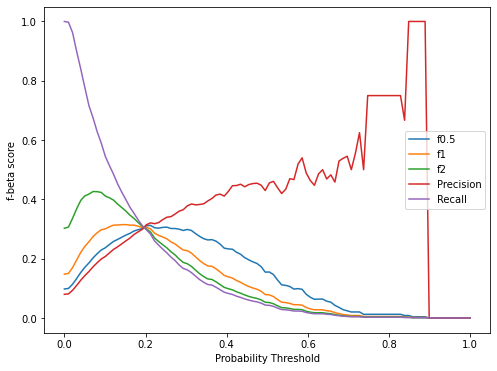

In [102]:
# Plot f_beta, precision, recall curves

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f0_5_scores , label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right');

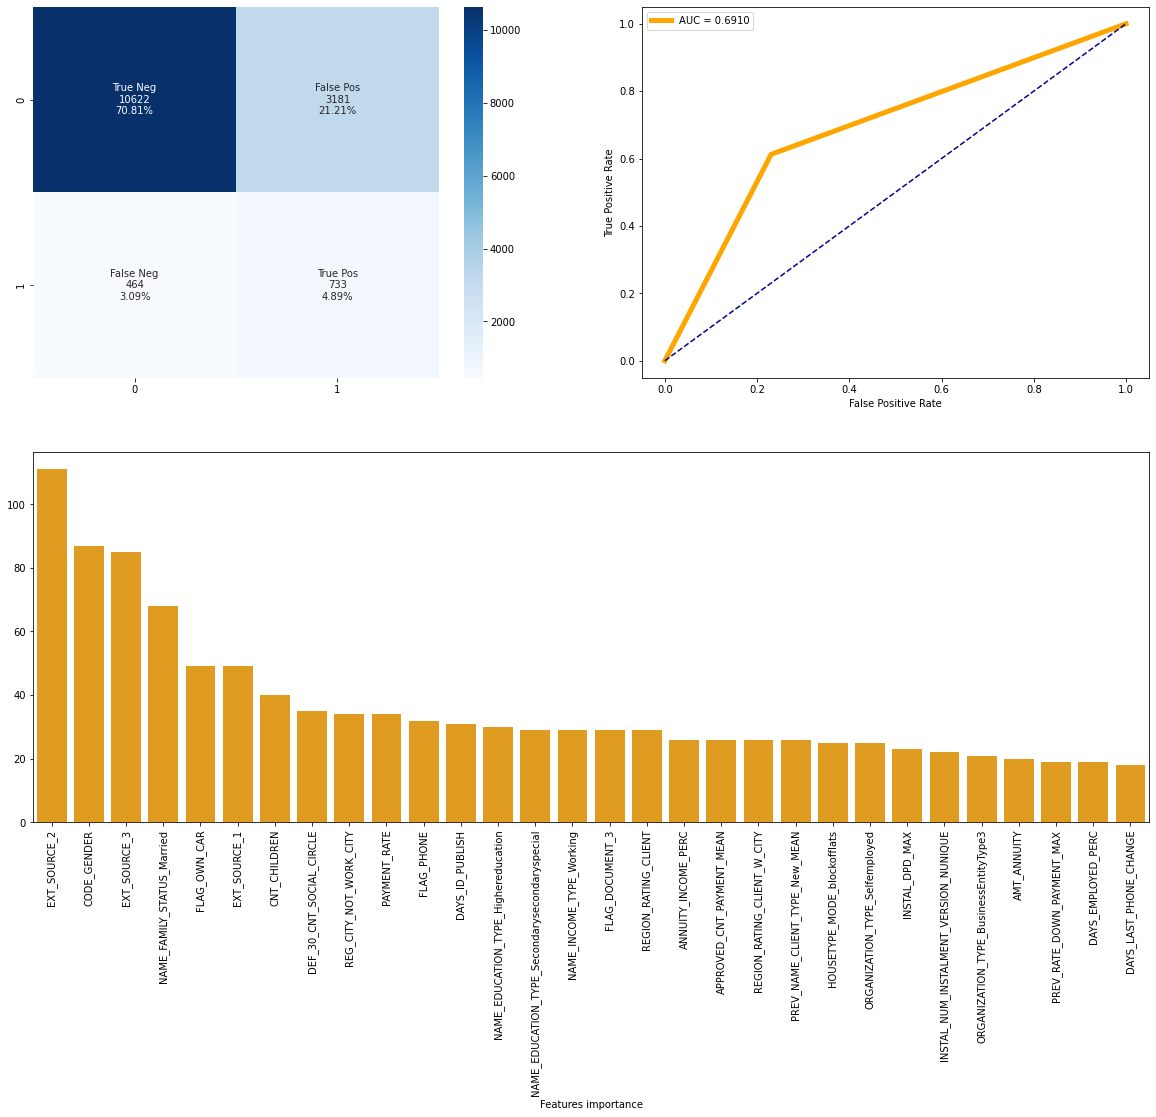

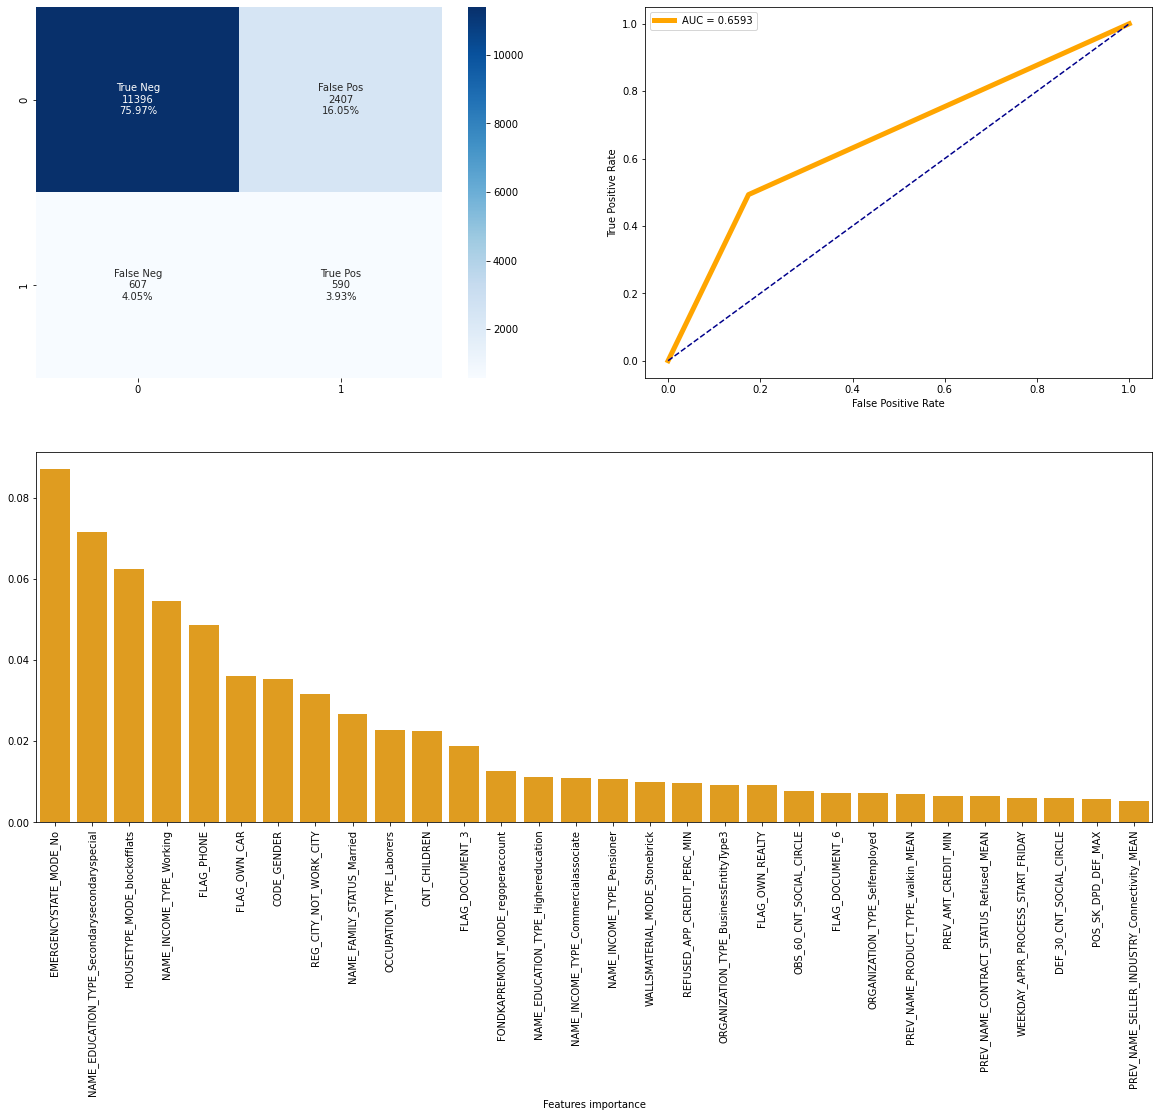

In [165]:
for model in models:
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.1).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred)
    # cf_matrix_roc_auc(model, y_test, model.predict(X_test), y_pred_proba, feature_importances=None)
    cf_matrix_roc_auc(model, y_test, y_pred, y_pred, feature_importances=True)

## Feature Importance locale avec Shap

In [19]:
models = [LGBMClassifier(),#device='gpu'),
          XGBClassifier()]#tree_method='gpu_hist', predictor='gpu_predictor')]

results_lgbm, lgbm = train_models(models[0], X_train_res, X_test, y_train_res, y_test)
results_xgboost, xgboost = train_models(models[1], X_train_res, X_test, y_train_res, y_test)

ValueError: too many values to unpack (expected 2)

In [26]:
# enregistrement des modèles

#pickle.dump(xgboost, open("dash/XGBOOSTClassifier.pkl", "wb"))
pickle.dump(model, open("model/LGBMClassifier.pkl", "wb"))

In [61]:
import shap
shap.initjs()

In [60]:

explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

#shap_vals = lin_reg_explainer1.shap_values(X_test[sample_idx])

 99%|===================| 14839/15000 [01:11<00:00]        

In [58]:
#shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[1][:], data.values)

IndexError: invalid index to scalar variable.

In [62]:
lin_reg_explainer1 = shap.TreeExplainer(model, X_train)

In [116]:
sample_idx = 5000

shap_vals = lin_reg_explainer1.shap_values(X_test[sample_idx])

print("Base Value : ", lin_reg_explainer1.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", model.predict(X_test[sample_idx].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value : ", lin_reg_explainer1.expected_value + shap_vals.sum())

Base Value :  -3.486598100900883

Shap Values for Sample 5000 :  [ 3.20132325e-02  0.00000000e+00 -1.23318496e-01  5.58772721e-02
  4.85856494e-02  6.21848103e-02 -8.50881496e-04 -6.07058627e-02
  4.42765940e-02  9.40446671e-02  1.34791297e-02 -9.74900378e-02
 -7.56961773e-02  1.29425285e-03 -5.77311704e-02 -1.13584466e-02
  0.00000000e+00  5.91654025e-03 -6.38717841e-03  0.00000000e+00
  4.47775248e-02  0.00000000e+00  7.95121843e-03 -2.60873857e-03
  1.57164154e-02 -1.21027998e-01  8.51054350e-04  2.17938744e-03
  1.18866175e-03 -6.99238330e-04  2.73631214e-02 -7.48297247e-02
  1.51941453e-01 -4.77057748e-01 -4.36779907e-01  1.97659727e-03
  6.48359291e-03 -2.30785479e-02 -8.95805657e-06  8.26563794e-03
  0.00000000e+00 -5.18633841e-03  0.00000000e+00 -3.25278863e-04
 -1.85246402e-03  5.02673365e-03 -2.21425603e-03  0.00000000e+00
 -5.84306229e-03  9.53261644e-03 -2.27163452e-02 -8.12475741e-03
 -7.42798299e-04  4.29298710e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.77714

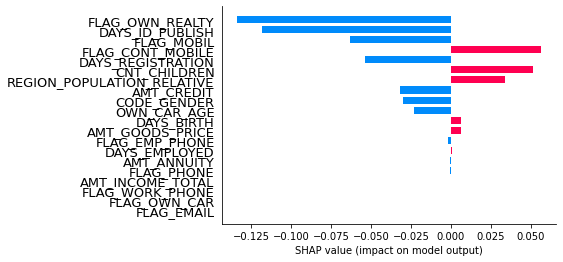

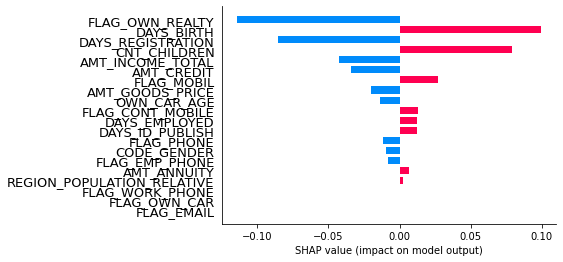

In [117]:
nb_top = 20
num_client = 100

models_trained = [lgbm, xgboost]
#model = xgboost

for model in models_trained:
    lin_reg_explainer1 = shap.TreeExplainer(model, X_train)
    shap_values = lin_reg_explainer1.shap_values(X_test[num_client])

    shap.bar_plot(lin_reg_explainer1.shap_values(X_test[num_client])[0:nb_top],
                  feature_names=data.columns.to_list(),
                  max_display=len(data.columns.to_list()))

In [1]:
shap.force_plot(lin_reg_explainer1.expected_value,
                lin_reg_explainer1.shap_values(X_test[num_client][0:nb_top]),
                feature_names=data.columns.to_list(),
                out_names="importance")

NameError: name 'shap' is not defined

In [12]:
data.index.values

array([100002, 100003, 100004, ..., 105847, 105848, 105849], dtype=int64)

In [21]:
data['CODE_GENDER'].value_counts()

1.0    3301
0.0    1699
Name: CODE_GENDER, dtype: int64

In [28]:
data = pd.read_csv('input_data_model2.zip', index_col='SK_ID_CURR', encoding ='utf-8')
data = data.drop('Unnamed: 0', 1)
data = data.drop('index', 1)

In [29]:
data

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
100003,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
100004,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
100006,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148411,0.0,0.0,1.0,0.0,1.0,135000.0,254700.0,27558.0,225000.0,0.025164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
148412,0.0,1.0,1.0,0.0,1.0,94500.0,568800.0,17307.0,450000.0,0.032561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0
148413,0.0,1.0,0.0,0.0,0.0,112500.0,808650.0,24601.5,675000.0,0.018634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
